# A/B Test - Power Calculations for the Design of Your Experiment

## Purpose : Finding the Right Sample Size For Your Experiment

#### The purpose of this notebook is to allow the users to adjust parameters for the A/B Test's experimental design. 

#### Since the experimental design's requirements for sample size for both arms of the experiment (control and treatment) vary according to select parameters, this notebook will serve as a walkthrough for the users in adjusting said parameters and what drawbacks and benefits those adjustments would entail. The contents of this notebook are as follows:

0) What is an A/B Test?
1) Import the data
2) Calculate the conversion rate
3) Deep Dive into each of the parameters we will need to understand for this A/B Test (Most Extensive Portion)
    - a)Effect Size, Relative and Absolute
    - b) Statistical Power, Running Away from Type False Negatives
    - c) Alpha - Running away from False Positives
4) Play around with the parameters...wisely
5) Notes on Evan Miller's Online A/B Test Calculator

#### One last very important thing to note for this introduction is that the validity of our calculations were originally cross checked with Evan Miller's Online A/B test calculator, the defacto online A/B Test calculator, and the method we use (tt_ind_solve_power from the python Stats power modules) yields extremely close results to the one's from Evan's calculator, often off between tens and slightly over a hundred at most. If you want to use the Evan Miller version of the calculator, already implemented as python code, you can skip to the end of the notebook, as the function identically mirrors what that online calculator generates for any test case. At the end of the notebook, we also explain why the power module was given preference.

#### **FOR THOSE SHORT ON TIME : Run all cells, skip to section 4 to play with the parameters to identify the sample size for your A/B Test. Otherwise, happy reading.**

## 0) What is an A/B Test?

#### An A/B test is a method used in marketing, web development, and product management (as well as other fields) to compare two versions of data, one with a treatment condition and one without the treatment condition. The objective is to statistically measure if said treatment is ineffective or effective. It is a way to demo an idea to assess its feasibility and potential success before deploying said treatment into the outside world. 

#### For example, if a website wants to test if a logo for a new feature captivates more users to click on said feature, they can test the new logo on a small group while testing the old logo on another group. If the new logo results in more uses of the feature, and there is statistical evidence to support this causality, then the website's managers can feel confident in rolling out the feature with the new logo on a permanent basis. 

#### Many more details go into an A/B test, but this is the high level understanding. For this notebook, we will focus on generating the sample size for your experiment. However, first we have to...

## 1) Import the Data

In [1]:
# run all imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
from statsmodels.stats.power import tt_ind_solve_power
import plotly.express as px
import warnings

In [15]:
# change the path accordingly
pathing = False
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    if pathing is True:
        # add your path here
        path = "../your_data.csv"
        your_data = pd.read_csv(path)
    
    else:
        # generate random data
        np.random.seed(42)
        n = 100
        your_data = pd.DataFrame({
            "X_1": np.random.normal(0, 1, n),
            "X_2": np.random.normal(0.5, 1, n)
        })
        # generate random binary data
        your_data["Outcome Metric"] = np.random.choice([0, 1], n)
        
        

In [16]:
# sanity check first rows
your_data.head()

,X_1,X_2,Outcome Metric
0,0.496714,-0.915371,1
1,-0.138264,0.079355,1
2,0.647689,0.157285,0
3,1.523030,-0.302277,1
4,-0.234153,0.338714,0


In [17]:
your_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   X_1             100 non-null    float64
 1   X_2             100 non-null    float64
 2   Outcome Metric  100 non-null    int32  
dtypes: float64(2), int32(1)
memory usage: 2.1 KB


## 2) Calculate the current conversion rate

#### Every other calculation in the A/B Test hinges primarily on this metric.

In [21]:
# Looking at the normalized values of the conversion rates
print(your_data["Outcome Metric"].value_counts(normalize=True))

Outcome Metric
1    0.57
0    0.43
Name: proportion, dtype: float64


In [20]:
conversion_rate = your_data["Outcome Metric"].value_counts(normalize=True)

conversion_rate = conversion_rate[conversion_rate.index.values == 1][1]

print(
    f"The conversion rate is {conversion_rate:.2f} (rounded)."
)

The conversion rate is 0.57 (rounded).


### After identifying a conversion rate, we can use this as the baseline for identifying which would be a proper goal to specify for an uplift (such as 1%, 5%, 10% and so forth).

## 3) Deep Dive: Specifying the function to calculate sample size  : tt_ind_solve_power

#### This function's entire purpose is to help the user find the necessary parameters to execute a two sample, independent T-test at the end to compare either means or proportions. The trick to using this function is to leave one parameter blank, as that is the parameter that will be estimated by the power function. Since the A/B test concludes with running a T-est fo the two group's conversion rates, that's why the T-test variant of the many power functions was chosen. The parameters are:

##### 1) effect_size - the improvement we want to see in the conversion rate or other metric (The lifts or effect sizes will be explained later)
##### 2) nobs - number of observations needed for the experiment (what we want to find)
##### 3) alpha - the desired significance level for the t-test
##### 4) power - the desired statistical power for the t-test

#### Ratio and alternative can be left alone, as the ratio means the observations for the second group, the treatment, which must always be identical to the control group. As for the hypothesis test, we definitely want the calculation to be two-sided, to look at both ends of the statistical tails of the test (not just when it is bigger or smaller).
#### Now for the effect size, a standardized effect for the tt_ind_solve_power function needs to be calculated prior, so that it yields correct results. As specified in the documentation, it's the "difference between the two means divided by the standard deviation. effect_size has to be positive."

#### Here is a very short demo of the function. 

In [22]:
# sample size is none, so sample size will be returned by the function

print(
    f"{tt_ind_solve_power(effect_size=0.05, nobs1=None, alpha=0.05, power=0.8, ratio = 1,  alternative='two-sided'):,.0f}",
    " is some arbitrary sample size for the demo",
)

6,280  is some arbitrary sample size for the demo


#### Now, let's commence the deep dives.

## a) Choosing an effect size

#### In short, effect size is how much uplift or reduction one wants to see imposed on the evaluation metric. Usually, in A/B tests, we have guardrail metrics that let us know how much room the main evaluation metric can increase or decrease without something going wrong (i.e. maintaining  amount of user comments (guardrail) while trying to increase likes to certain types of posts (primary metric)). If you have a guardrail metric, make sure to identify it from the onset.

#### A key nuanced trait about effect size is knowing which type one wants : Relative or Absolute. Relative Lift is when one wants to detect percentage point changes from a baseline, a type of normalized comparison regardless of where the treatment is applied. In this case, the purpose of the A/B test is to check if said relative lift is accomplished with the experiments. Example below:
$\frac{a - b}{a} = \frac{{|15 - 18|}}{{15}} = 0.20$ 

#### or 20 percentage points. 0.20 is your relative lift.




#### Absolute lift on the other hand is more intuitive. It is just a raw increase to the baseline metric, which forces the user to always have a baseline metric in order to define this effect size. If the baseline is 25% with a goal of 30% increase, the absolute lift is 5%.

$0.30 - 0.25 = 0.05 $

#### As always, regardless of lift, understand your problem well enough to know which lift type to use. Fair warning, relative lifts are very hungry in terms of sample sizes. The smaller the effect, the higher the sample size required to detect it. This size that is calculated is for both treatment arms (control and treatment). If the result is an N of 100 for a given effect size, it means an N of 100 in both arms, not split across them\.

In [23]:
# you can change this parameter to see how the sample size changes
# we are going to use this for a demonstration of the effect size on sample size
mde = 0.02  # minimum detectable effect

In [24]:
variance = conversion_rate * (1 - conversion_rate)  # p * (1 - p)
print(f"The variance of the conversion rate is {variance:.4f} (rounded).")

The variance of the conversion rate is 0.2451 (rounded).


#### Note : We are dealing with a binomial distribution because the outcome of this problem is :

1) Did they convert?
- Yes or No

The variance for this single group, as it is currently known:
$$\text{Var}(X) = np(1-p)$$

However, because we want to compare the variance of two groups (not individual trials), the n for this group is 1.

#### Leaving all other parameters untouched, let's see the changes of effect size on sample size, using the current data's conversion rate.

In [25]:
# we need to standardize the effect size for the tt_ind_solve_power function
standardized_effect_size = (abs(conversion_rate - (conversion_rate + mde))) / np.sqrt(
    variance
)
print(f"My standardized effect size is {standardized_effect_size:.4f}.")

My standardized effect size is 0.0404.


In [26]:
# Example of absolute lift

ss_demo_abslift = tt_ind_solve_power(
    effect_size=standardized_effect_size,
    nobs1=None,
    alpha=0.05,
    power=0.8,
    ratio=1,
    alternative="two-sided",
)
print(f"The sample size for the demo absolute lift is {ss_demo_abslift:,.0f}.")

The sample size for the demo absolute lift is 9,620.


In [27]:
demo_abslift_list = [
    ((abs(conversion_rate - (conversion_rate + mde))) / np.sqrt(variance))
    for mde in np.arange(0.01, 0.20, 0.01)
]
demo_abslift_ss = [
    tt_ind_solve_power(
        effect_size=effect_size,
        nobs1=None,
        alpha=0.05,
        power=0.8,
        ratio=1,
        alternative="two-sided",
    )
    for effect_size in demo_abslift_list
]
demo_abslift_df = pd.DataFrame(
    {
        "effect_size": [mde for mde in np.arange(0.01, 0.20, 0.01)],
        "sample_size": [int(ss) for ss in demo_abslift_ss],
    }
)

fig = px.line(
    demo_abslift_df,
    x="effect_size",
    y="sample_size",
    title="Sample Size vs. Absolute Lift : Observe the harsh sample size requirements for small effect sizes",
    labels={"effect_size": "Absolute Lift", "sample_size": "Sample Size"},
)

fig.show()

In [28]:
# example of relative lift

relative_mde = conversion_rate * mde
standardized_effect_size = (
    conversion_rate - (conversion_rate + relative_mde)
) / np.sqrt(variance)

ss_demo_rellift = tt_ind_solve_power(
    effect_size=standardized_effect_size,
    nobs1=None,
    alpha=0.05,
    power=0.8,
    ratio=1,
    alternative="two-sided",
)

print(f"The sample size for the demo relative lift is {ss_demo_rellift:,.0f}.")

The sample size for the demo relative lift is 29,606.


In [29]:
demo_rellift_list = [
    (
        (abs(conversion_rate - (conversion_rate + conversion_rate * mde)))
        / np.sqrt(variance)
    )
    for mde in np.arange(0.01, 0.20, 0.01)
]
demo_rellift_ss = [
    tt_ind_solve_power(
        effect_size=effect_size,
        nobs1=None,
        alpha=0.05,
        power=0.8,
        ratio=1,
        alternative="two-sided",
    )
    for effect_size in demo_rellift_list
]

demo_rellift_df = pd.DataFrame(
    {
        "effect_size": [mde for mde in np.arange(0.01, 0.20, 0.01)],
        "sample_size": [int(ss) for ss in demo_rellift_ss],
    }
)

fig = px.line(
    demo_rellift_df,
    x="effect_size",
    y="sample_size",
    title="Sample Size vs. Relative Lift : 100s of thousands of samples for small effect sizes!",
    labels={"effect_size": "Relative Lift", "sample_size": "Sample Size"},
)

fig.show()

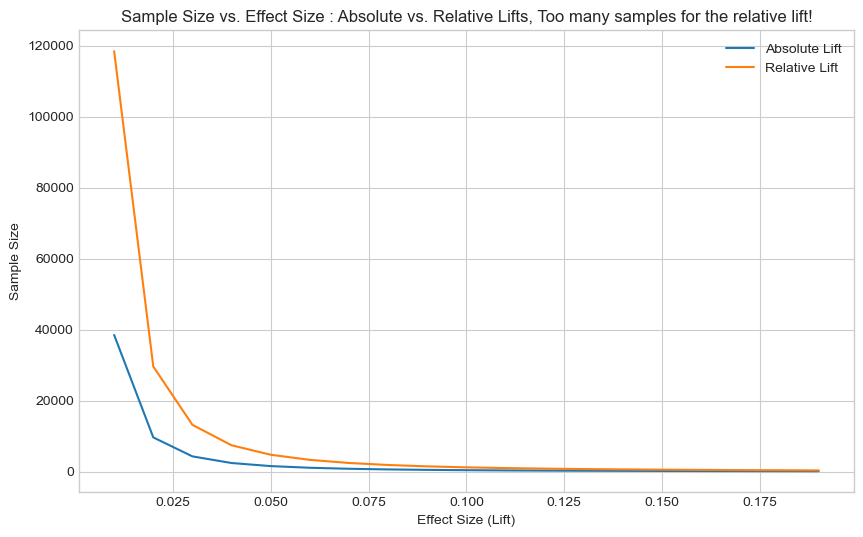

In [30]:
# plot the two together
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    plt.style.use("seaborn-whitegrid")

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(
        demo_abslift_df["effect_size"],
        demo_abslift_df["sample_size"],
        label="Absolute Lift",
    )

    ax.plot(
        demo_rellift_df["effect_size"],
        demo_rellift_df["sample_size"],
        label="Relative Lift",
    )

    ax.set_title(
        "Sample Size vs. Effect Size : Absolute vs. Relative Lifts, Too many samples for the relative lift!"
    )

    ax.set_xlabel("Effect Size (Lift)")

    ax.set_ylabel("Sample Size")

    ax.legend()

    plt.show()


#### Moral of the story : Pick the right lift for your problem and agree with your stakeholder on finding a reasonable effect to aim towards detecting and an effect that your stakeholder needs to justify this converting this treatment into a full feature for the long term. 

#### Let's move to statistical power.

## b) Statistical Power : Chasing away the False Negatives

#### When comparing different groups for an A/B test or two different groups regardless of the type of test, we typically expect the distributions of the groups to be the same or different (in terms of means, standard deviations, variance, etc.). Before we continue, let's look at the graph below.

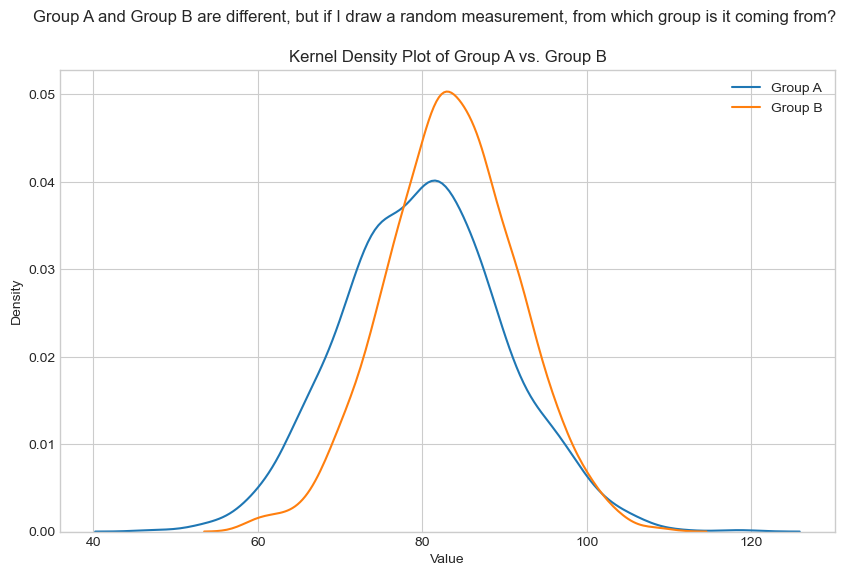

In [31]:
# Set the random seed for reproducibility
np.random.seed(42)

# Generate data for Group A (normal distribution with mean=80, std=10)
group_a_data = np.random.normal(loc=80, scale=10, size=1000)

# Generate data for Group B (normal distribution with mean=85, std=8)
group_b_data = np.random.normal(loc=83, scale=8, size=1000)

# Code where you want to silence warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")  # Ignore all warnings within this block
    # plot the data as a kernel density plot

    plt.style.use("seaborn-whitegrid")

    fig, ax = plt.subplots(figsize=(10, 6))

    sns.kdeplot(group_a_data, label="Group A", ax=ax)

    sns.kdeplot(group_b_data, label="Group B", ax=ax)

    ax.set_title("Kernel Density Plot of Group A vs. Group B")

    plt.suptitle(
        "Group A and Group B are different, but if I draw a random measurement, from which group is it coming from?"
    )

    ax.set_xlabel("Value")

    ax.set_ylabel("Density")

    ax.legend()

    plt.show()

#### If we draw a random measurement near the mean of 80, what distribution is it coming from? We don't know. What we do know is that both distributions are a little different. If we sampled from both of those groups and ran t-tests, our concern would be making sure to reject the null hypothesis (both distributions are the same) often. This ties back to the A/B test because we want to be able to correctly and often reject the null hypothesis that the treatment does not work (assuming that the treatment does in fact produce different results). This is statistical power, increasing our rate of correctly rejecting the null hypothesis or diminishing the rate of false negatives, saying the null hypothesis is true, when, in reality, it isn't. See the spikes below.

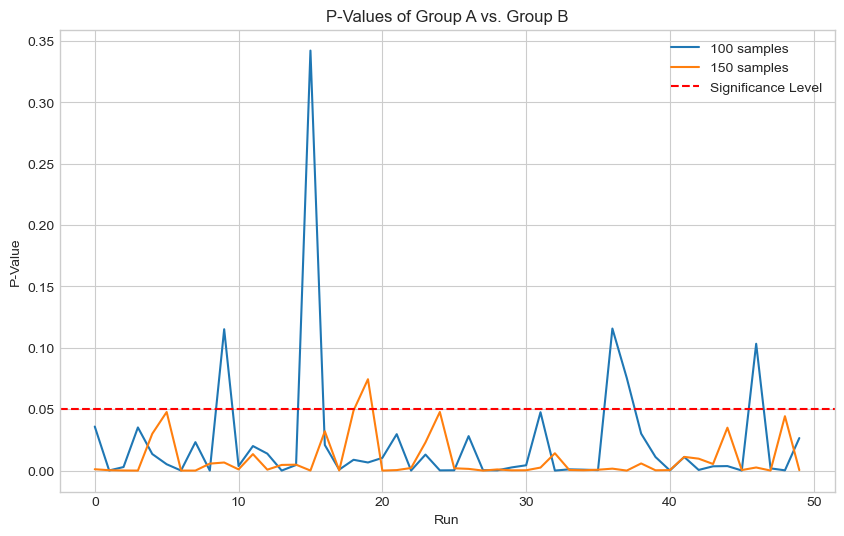

In [32]:
from scipy.stats import ttest_ind

p_values = []
runs = []

p_values_more_power = []
runs_more_power = []

for i in range(50):
    np.random.seed(i)
    sample_from_group_a = np.random.choice(group_a_data, size=100, replace=False)
    sample_from_group_b = np.random.choice(group_b_data, size=100, replace=False)
    runs.append(i)
    p_values.append(ttest_ind(sample_from_group_a, sample_from_group_b).pvalue)

    sample_from_group_a_more_power = np.random.choice(
        group_a_data, size=150, replace=False
    )
    sample_from_group_b_more_power = np.random.choice(
        group_b_data, size=150, replace=False
    )
    runs_more_power.append(i)
    p_values_more_power.append(
        ttest_ind(sample_from_group_a_more_power, sample_from_group_b_more_power).pvalue
    )

# plot the p-values of both groups
# Code where you want to silence warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")  # Ignore all warnings within this block

    plt.style.use("seaborn-whitegrid")

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(runs, p_values, label="100 samples")

    ax.plot(runs_more_power, p_values_more_power, label="150 samples")

    ax.axhline(y=0.05, color="r", linestyle="--", label="Significance Level")

    ax.set_title("P-Values of Group A vs. Group B")

    ax.set_xlabel("Run")

    ax.set_ylabel("P-Value")

    ax.legend()

    plt.show()

#### To us, the distribution is different, but we are getting some hypothesis tests rejected for some of those sample pairs (t-tests on different pairs of samples of A and B). What if we throw more power? That's the orange line we get there. It looks like we are rejecting the Null Hypothesis more often, which in our case, is good because the distributions are different.

#### HOWEVER, this is for demonstration purposes, as we are essentially p-hacking this example. P-hacking is screwing with the sample sizes to make things statistically significant when they weren't. For A/B tests, we need to get power right from the very beginning.

#### Now, let's look at the effect of statistical power on sample sizes. For this demonstration, we will assume a minimum effect size of 2%, absolute lift and use our original data.

In [33]:
mde = 0.02  # minimum detectable effect
standardized_effect_size = (abs(conversion_rate - (conversion_rate + mde))) / np.sqrt(
    variance
)

demo_statistical_power = [
    tt_ind_solve_power(
        effect_size=standardized_effect_size,
        nobs1=None,
        alpha=0.05,
        power=parameter_power,
        ratio=1,
        alternative="two-sided",
    )
    for parameter_power in np.arange(0.5, 0.95, 0.1)
]

demo_statistical_power_df = pd.DataFrame(
    {
        "power": [parameter_power for parameter_power in np.arange(0.5, 0.95, 0.1)],
        "sample_size": [int(ss) for ss in demo_statistical_power],
    }
)

fig = px.line(
    demo_statistical_power_df,
    x="power",
    y="sample_size",
    title="Sample Size vs. Statistical Power : More power means more samples!",
    labels={"power": "Statistical Power", "sample_size": "Sample Size"},
    color_discrete_sequence=["#F23869"],
)

fig.show()

#### Summary : More power needs more samples and more often correctly rejecting the null hypothesis. 80% power means we correctly reject the null hypothesis (or get statistically significant p-values for our t-tests for the A/B tests) 8 times out of 10. The other 2 times are false negatives. 80% tends to be a good baseline; however, because this parameter is essential to correctly rejecting the null hypothesis often, it is difficult to recommend exercising full freedom when playing with it, completely unlike the minimum detectable effect (which is likely in a range of usable or acceptable effects for a stakeholder).

## c) Alpha, Running Away From False Positives

### Alpha, the p-value for assessing that a test is statistically significant. It is also the concept with which we are most likely familiar. In short, a p-value for the significance test is a composite quantity that contains a sum of how rare an event is, how many events are there with equal rarity, and how many events are rarer than the observed event. In short, this probability sum is a value that essentially tells us if what we are observing is due to chance or not. In the context of hypothesis testing, if the null hypothesis is that two distributions are the same, a p-value will help us gather evidence for some degree of causality to reject or not reject the null hypothesis. If a p-value for a t-test is below the threshold of our choosing, it is statistically significant, and can help us reject the null hypothesis for our given problem. Conversely, if it isn't below the threshold, we have no evidence to reject the null hypothesis.

### However, a more practical way to think about p-values is the following. Let's borrow the graph from the statistical power demo. Our threshold for the demonstration was 0.05. This means that we are postulating that 95% of the tests that we run, a phenomenon that we are observing and statistically testing, were not due to random chance. If this is the case, we can reject the null hypothesis, no matter what it is. For the remaining 5% of the tests, we will be getting False Positives, instances where we believe that the data or phenomenon is ocurring due to some reasosn, when, in reality, it was a random ocurrence. To make it very concrete, using the graph below, the 20th run (blue line with a p-value below the threshold) shows that when comparing group scores, we have evidence to reject the null hypothesis that the two distributions are the same. If we were to run this test a 100 times, we expect 5 of them to be false positives. 

### What happens when we have a high p-value? Simple, we apply the same logic. The 15th run (the blue line with the spike) has a p-value above the threshold. Not only that, it's absurdly high. It's near 0.35. In layman's terms, 65% of the time, this difference in scores is due to some reason that is not chance, but for 35% of the time, it is random. 35% of the tests will also be false positives. It sounds awful to have a test result like this, doesn't it? You can't trust it.


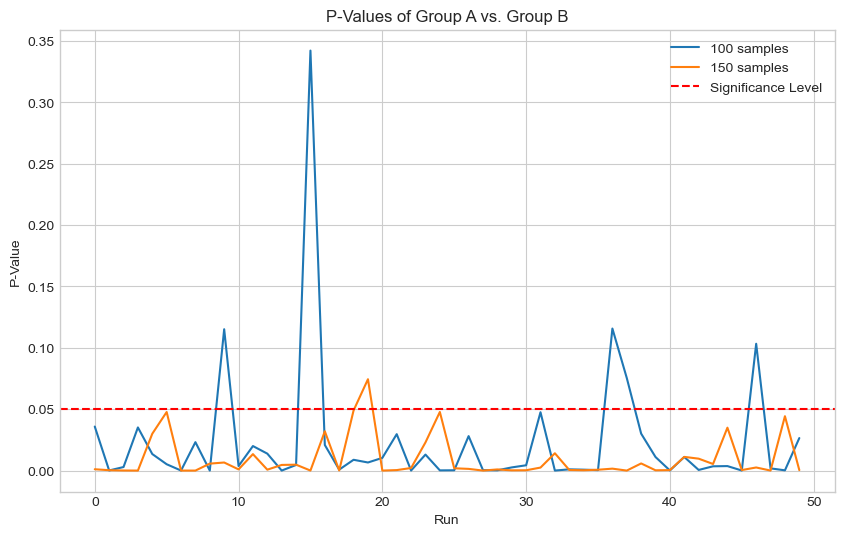


### This is the moral of the story. Significance thresholds are commitments to experimental design, detecting an effect within a certain range, and allowing a certain degree of false positives to enter the scope of all of your tests. For this A/B test, a false positive means that the shortening the structure of the application did nothing. Let's look at the effects of significance thresholds on our data. Like before, we assume an MDE of 2%, absolute lift, a power of 80% to estimate sample size while adjusting the significance threshold. As you have seen before, a similar tradeoff of a lower significance threshold means more samples. Let's coalesce all these elements together in the next section.


In [34]:
mde = 0.02  # minimum detectable effect
standardized_effect_size = (abs(conversion_rate - (conversion_rate + mde))) / np.sqrt(
    variance
)

demo_alpha_ss = [
    tt_ind_solve_power(
        effect_size=standardized_effect_size,
        nobs1=None,
        alpha=parameter_alpha,
        power=0.80,
        ratio=1,
        alternative="two-sided",
    )
    for parameter_alpha in np.arange(0.01, 0.2, 0.01)
]

demo_alpha_ss_df = pd.DataFrame(
    {
        "alpha": [parameter_alpha for parameter_alpha in np.arange(0.01, 0.2, 0.01)],
        "sample_size": [int(ss) for ss in demo_alpha_ss],
    }
)

fig = px.line(
    demo_alpha_ss_df,
    x="alpha",
    y="sample_size",
    title="Sample Size vs. Significance Threshold : Less alpha means more samples!",
    labels={"alpha": "Significance Threshold", "sample_size": "Sample Size"},
    color_discrete_sequence=["#d51b21"],
)

fig.show()

## 4) Play with the parameters...wisely.

#### You have likely done a lot of reading thus far, and for that, I thank you. Now, we cut straight to the point. How do you design and choose good parameters for the A/B test. there are tradeoffs no matter what you do. Let's quickly summarize them.

- #### Smaller MDE, more samples. If it's relative lift, even more samples.
- #### More statistical power, more samples and less False Negatives or less failed rejections of the null hypothesis.
- #### Smaller significance threshold, more samples and less false positives or less instances of saying there was a difference (t-test in our case) between groups of data when there wasn't. 

#### Your true answer to what to pick for these parameters is time and sample size. A/B tests are typically run between 2 and 4 weeks. For your specific case, you may even want to run it for longer depending on the nature of your problem.


### Summarized Recommendations:

#### The first issue that must be addressed is getting a truly accurate estimate for the conversion rate. 

##### Path A - You can start by using the tt_ind_solve_power function to solve for all the other parameters if you have a sample size in mind.

#### Path B - The steps are successive:

##### 1) Decide on statistical power, as that informs the risk of how you can falsely fail to reject the null hypothesis (when there is an effective treatment). Typically, this number should be high because falsely rejecting the presence of an effect a high % of the time is counterproductive.

##### 2) Proceed to decide a significance threshold. Understand what a false positive means in the context of your problem. Is it truly bad to have them? Use a higher alpha. Is it not that pressing? You have more freedom for choosing values of alpha. 

##### 3) Decide on a minimum effect size based on how feasible the sample size allocation for the control and treatment arms could be.

##### 4) Decide if you can run the test for 2, 4 or even 12 weeks (quarter length).

#### Note on False Positives for problems where FPs don't cause negative outcomes: a false positive means there is falsely reported, statistically significant difference between two groups when there isn't any at all. This is very interesting. If both groups have a falsely reported statistically meaningful differences between their conversion rates, the worst case scenario for the problem at hand is a treatment that achieved a similar conversion rate to the control. As a false positive, it tends to be less harmful than a lower Power, which is much more damaging to the analysis, given that it limits the possibility of correctly rejecting the null hypothesis frequently. In short, there may be some leeway to using a larger significance threshold when the false positives cause no harm for the user. 

#### An example of this is classifying e-mails as SPAM. Accidentally classifying promotional e-mails as SPAM (False Positive) is an inconvenience for the user, but nowhere near as harmful as classifying personal e-mails or work e-mails as SPAM (Worse False Positive). Go play with the parameters!!!


In [35]:
def play_with_abtest_parameters(
    conversion_rate: float,
    mde: float,
    alpha: float,
    power: float,
    play_with: str,
    range_to_play: list,
) -> int:
    """Returns the sample size for a given set of parameters."""
    variance = conversion_rate * (1 - conversion_rate)
    standardized_effect_size = (
        abs(conversion_rate - (conversion_rate + mde))
    ) / np.sqrt(variance)

    if play_with == "effect_size":
        sample_size = [
            tt_ind_solve_power(
                effect_size=(abs(conversion_rate - (conversion_rate + effect_size)))
                / np.sqrt(variance),
                nobs1=None,
                alpha=alpha,
                power=power,
                ratio=1.0,
                alternative="two-sided",
            )
            for effect_size in range_to_play
        ]

    elif play_with == "alpha":
        sample_size = [
            tt_ind_solve_power(
                effect_size=standardized_effect_size,
                nobs1=None,
                alpha=modular_alpha,
                power=power,
                ratio=1.0,
                alternative="two-sided",
            )
            for modular_alpha in range_to_play
        ]

    elif play_with == "power":
        sample_size = [
            tt_ind_solve_power(
                effect_size=standardized_effect_size,
                nobs1=None,
                alpha=alpha,
                power=modular_power,
                ratio=1.0,
                alternative="two-sided",
            )
            for modular_power in range_to_play
        ]

    plot_df = pd.DataFrame(
        {
            play_with: range_to_play,
            "sample_size": [int(ss) for ss in sample_size],
        }
    )

    fig = px.line(
        plot_df,
        x=play_with,
        y="sample_size",
        title=f"Sample Size vs. {play_with} : {play_with} is the parameter being played with",
        labels={play_with: play_with, "sample_size": "Sample Size"},
    )

    fig.show()

    return sample_size

In [36]:
# Playground

# mutable parameters

mde = 0.02  # minimum detectable effect
significance_threshold = 0.05
power_desired = 0.80


# play with the effect size
test_ground = play_with_abtest_parameters(
    conversion_rate=conversion_rate,
    mde=mde,
    alpha=significance_threshold,
    power=power_desired,
    play_with="effect_size",
    range_to_play=[i / 100 for i in range(1, 20)],
)

#### Thanks for reading thus far. Play with the parameters to your heart's content in order to design and complete a feasible experiment. I hope your A/B Test is a success, and I hope your conversion rate increases plentifully. Thank you!!!

## 5) Notes on the Evan Miller Calculator

#### The reason why it was opted to use the power modules was for the comfort of those who prefer to use official python modules for statistical tests. In comparison to the Evan Miller implementation, it was consistently different by a few tens to roughly over a hundred (always less than the EM variant) for the comparison estimates that I ran. I will show also cite the Evan Miller implementation below by Geoff.

In [37]:
import numpy as np
import scipy.stats


def calc_sample_size(alpha, power, p, pct_mde, delta_type="relative", num_tails="two"):
    """Based on https://www.evanmiller.org/ab-testing/sample-size.html and Geoff's (https://stats.stackexchange.com/users/127726/geoff) Python implementation of the same.

        Cited from https://stats.stackexchange.com/questions/357336/create-an-a-b-sample-size-calculator-using-evan-millers-post
    Args:
        alpha (float): How often are you willing to accept a Type I error (false positive)?
        power (float): How often do you want to correctly detect a true positive (1-beta)?
        p (float): Base conversion rate
        pct_mde (float): Minimum detectable effect
        delta_type (str): either 'relative' or 'absolute'
        num_tails (str): either 'one' or 'two'
    """

    delta = p * pct_mde
    if delta_type == "absolute":
        delta = pct_mde

    t_alpha2 = scipy.stats.norm.ppf(1.0 - alpha / 2)
    if num_tails == "one":
        t_alpha2 = scipy.stats.norm.ppf(1.0 - alpha)
    t_beta = scipy.stats.norm.ppf(power)

    sd1 = np.sqrt(2 * p * (1.0 - p))
    sd2 = np.sqrt(p * (1.0 - p) + (p + delta) * (1.0 - p - delta))

    return (
        (t_alpha2 * sd1 + t_beta * sd2)
        * (t_alpha2 * sd1 + t_beta * sd2)
        / (delta * delta)
    )

In [38]:
standardized_effect_size = (abs(conversion_rate - (conversion_rate + mde))) / np.sqrt(
    variance
)

print(f"My standardized effect size is {standardized_effect_size:.4f}.")

My standardized effect size is 0.0404.


In [39]:
# absolute lift

ss_demo_abslift = tt_ind_solve_power(
    effect_size=standardized_effect_size,
    nobs1=None,
    alpha=0.05,
    power=0.8,
    ratio=1,
    alternative="two-sided",
)
print(
    f"The main power function used in this notebook : The sample size for the demo absolute lift is {ss_demo_abslift:,.0f}."
)

ss_demo_abslift_EM = calc_sample_size(
    alpha=0.05,
    power=0.8,
    p=conversion_rate,
    pct_mde=mde,
    delta_type="absolute",
    num_tails="two",
)

print(
    f"The Evan Miller method : The sample size for the demo absolute lift is {ss_demo_abslift_EM:,.0f}."
)

The main power function used in this notebook : The sample size for the demo absolute lift is 9,620.
The Evan Miller method : The sample size for the demo absolute lift is 9,600.


### <center> Evan Miller's calculations, barely different. (Absolute Lift) 

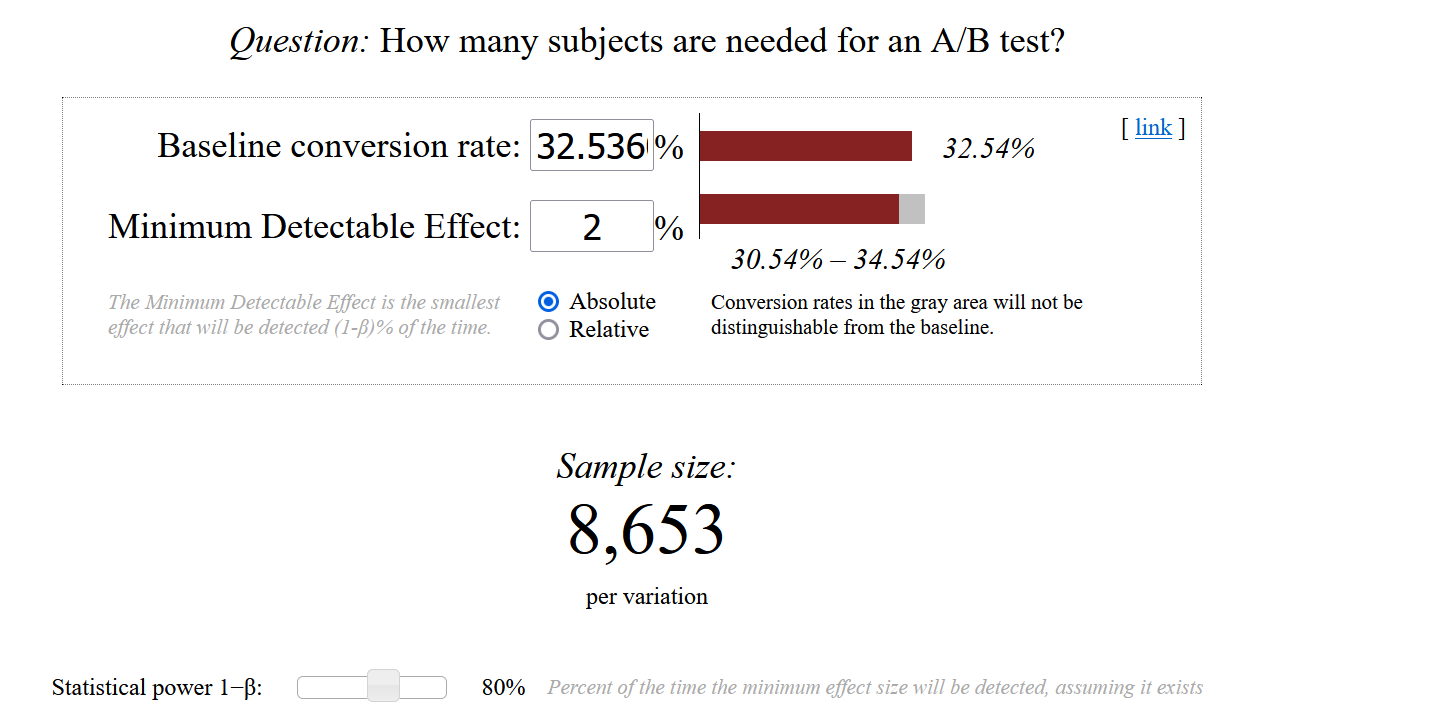

In [40]:
# relative lift

relative_mde = conversion_rate * mde
standardized_effect_size = (
    conversion_rate - (conversion_rate + relative_mde)
) / np.sqrt(variance)

ss_demo_rellift = tt_ind_solve_power(
    effect_size=standardized_effect_size,
    nobs1=None,
    alpha=0.05,
    power=0.8,
    ratio=1,
    alternative="two-sided",
)

print(
    f"The main power function used in this notebook :sample size for the demo relative lift is {ss_demo_rellift:,.0f}."
)

ss_demo_rellift_EM = calc_sample_size(
    alpha=0.05,
    power=0.8,
    p=conversion_rate,
    pct_mde=mde,
    delta_type="relative",
    num_tails="two",
)

print(
    f"The Evan Miller method : sample size for the demo relative lift is {ss_demo_rellift_EM:,.0f}."
)

The main power function used in this notebook :sample size for the demo relative lift is 29,606.
The Evan Miller method : sample size for the demo relative lift is 29,574.


### <center> Evan Miller's calculations, barely different. (Relative Lift)

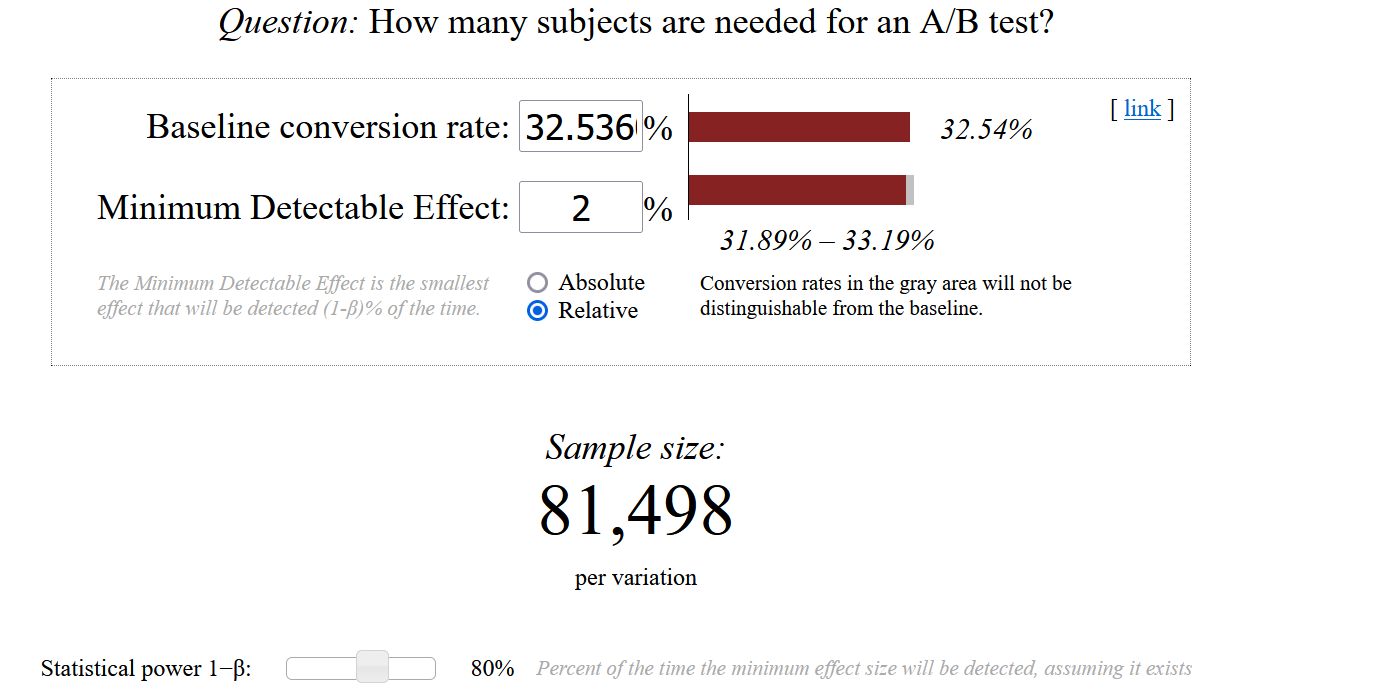

In [41]:
def play_Evan_Miller_abtest_parameters(
    conversion_rate: float,
    mde: float,
    alpha: float,
    power: float,
    play_with: str,
    range_to_play: list,
    delta_type: str,
    num_tails: str,
) -> int:
    """Returns the sample size for a given set of parameters."""

    if play_with == "effect_size":
        sample_size = [
            calc_sample_size(
                alpha=alpha,
                power=power,
                p=conversion_rate,
                pct_mde=modular_mde,
                delta_type=delta_type,
                num_tails=num_tails,
            )
            for modular_mde in range_to_play
        ]

    elif play_with == "alpha":
        sample_size = [
            calc_sample_size(
                alpha=modular_alpha,
                power=power,
                p=conversion_rate,
                pct_mde=mde,
                delta_type=delta_type,
                num_tails=num_tails,
            )
            for modular_alpha in range_to_play
        ]

    elif play_with == "power":
        sample_size = [
            calc_sample_size(
                alpha=alpha,
                power=modular_power,
                p=conversion_rate,
                pct_mde=mde,
                delta_type=delta_type,
                num_tails=num_tails,
            )
            for modular_power in range_to_play
        ]

    plot_df = pd.DataFrame(
        {
            play_with: range_to_play,
            "sample_size": [int(ss) for ss in sample_size],
        }
    )

    fig = px.line(
        plot_df,
        x=play_with,
        y="sample_size",
        title=f"Evan Miller Version: Sample Size vs. {play_with} : {play_with} is the parameter being played with",
        labels={play_with: play_with, "sample_size": "Sample Size"},
    )

    fig.show()

    return sample_size

In [42]:
# Playground for Evan Miller's method

# mutable parameters

mde = 0.02  # minimum detectable effect
significance_threshold = 0.05
power_desired = 0.80

# play with the effect size
test_ground = play_Evan_Miller_abtest_parameters(
    conversion_rate=conversion_rate,
    mde=mde,
    alpha=significance_threshold,
    power=power_desired,
    play_with="effect_size",
    range_to_play=[i / 100 for i in range(1, 20)],
    delta_type="relative",
    num_tails="two",
)